# 2: Word2Vec + BiLSTM

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, numpy as np, pandas as pd

PROJECT_DIR = r"C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2"
DATA_PATH   = rf"{PROJECT_DIR}\jarvis-calling-hiring-contest\Resume\Resume.csv"

TEXT_COL  = "Resume_str"
LABEL_COL = "Category"

SEED = 42
np.random.seed(SEED)

# Si ya existen en la sesión, reusamos; si no, creamos
try:
    train_df, val_df, test_df
except NameError:
    from sklearn.model_selection import train_test_split
    df = pd.read_csv(DATA_PATH).dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    train_df, temp_df = train_test_split(df, test_size=0.20, random_state=SEED, stratify=df[LABEL_COL])
    val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df[LABEL_COL])

print("train/val/test:", train_df.shape, val_df.shape, test_df.shape)

# Mapeo de etiquetas
all_labels = sorted(train_df[LABEL_COL].unique())
label2id = {c:i for i,c in enumerate(all_labels)}
id2label = {i:c for c,i in label2id.items()}
NUM_CLASSES = len(all_labels)
NUM_CLASSES


train/val/test: (1987, 4) (248, 4) (249, 4)


24

In [3]:
import re, unicodedata

def clean_text_min(s: str) -> str:
    if not isinstance(s, str): return ""
    s = unicodedata.normalize("NFKC", s).lower()
    s = re.sub(r"<[^>]+>", " ", s)                   # quita HTML simple
    s = re.sub(r"[^\w\s]", " ", s, flags=re.UNICODE) # deja letras/números/espacios
    s = re.sub(r"\s+", " ", s).strip()
    return s

def simple_tokenize(s: str):
    s = clean_text_min(s)
    return s.split()

# Tokeniza corpus (solo una vez)
train_tokens = [simple_tokenize(t) for t in train_df[TEXT_COL].tolist()]
val_tokens   = [simple_tokenize(t) for t in val_df[TEXT_COL].tolist()]
test_tokens  = [simple_tokenize(t) for t in test_df[TEXT_COL].tolist()]

y_train = train_df[LABEL_COL].map(label2id).values.astype(np.int64)
y_val   = val_df[LABEL_COL].map(label2id).values.astype(np.int64)
y_test  = test_df[LABEL_COL].map(label2id).values.astype(np.int64)

len(train_tokens), len(val_tokens), len(test_tokens), NUM_CLASSES


(1987, 248, 249, 24)

In [4]:
from collections import Counter

MAX_VOCAB = 50000      # puedes subir/bajar
PAD, UNK = "<pad>", "<unk>"

def build_vocab(token_lists, max_vocab=MAX_VOCAB):
    cnt = Counter()
    for toks in token_lists:
        cnt.update(toks)
    most_common = [w for w,_ in cnt.most_common(max_vocab-2)]
    itos = [PAD, UNK] + most_common
    stoi = {w:i for i,w in enumerate(itos)}
    return itos, stoi

itos, stoi = build_vocab(train_tokens, MAX_VOCAB)
vocab_size = len(itos)
vocab_size


36218

In [5]:
def encode_tokens(token_lists, stoi_map, seq_len):
    X = np.zeros((len(token_lists), seq_len), dtype=np.int64)  # PAD=0
    for i, toks in enumerate(token_lists):
        ids = [stoi_map.get(t, 1) for t in toks]               # UNK=1
        ids = ids[:seq_len]
        X[i, :len(ids)] = ids
    return X

# cachés para no recomputar al variar seq_len
_X_cache = {}
def get_encoded(seq_len):
    if seq_len not in _X_cache:
        Xtr = encode_tokens(train_tokens, stoi, seq_len)
        Xva = encode_tokens(val_tokens,   stoi, seq_len)
        Xte = encode_tokens(test_tokens,  stoi, seq_len)
        _X_cache[seq_len] = (Xtr, Xva, Xte)
    return _X_cache[seq_len]


In [6]:
from gensim.models import Word2Vec
import numpy as np, os

_w2v_cache = {}    # {emb_dim: gensim_model}
_emb_cache = {}    # {emb_dim: np.ndarray [vocab_size, emb_dim]}

def train_word2vec(token_lists, emb_dim=100, window=5, min_count=1, sg=1, negative=5, epochs=10):
    # cachea por dimensión
    if emb_dim in _w2v_cache:
        return _w2v_cache[emb_dim]
    w2v = Word2Vec(
        sentences=token_lists, vector_size=emb_dim, window=window,
        min_count=min_count, sg=sg, negative=negative, workers=max(1, os.cpu_count()-1), epochs=epochs, seed=SEED
    )
    _w2v_cache[emb_dim] = w2v
    return w2v

def build_embedding_matrix(w2v, itos):
    emb_dim = w2v.vector_size
    if emb_dim in _emb_cache:
        return _emb_cache[emb_dim]
    M = np.random.uniform(-0.05, 0.05, size=(len(itos), emb_dim)).astype(np.float32)
    M[0] = 0.0   # PAD=0 vector cero
    for idx, tok in enumerate(itos):
        if tok in w2v.wv:
            M[idx] = w2v.wv[tok]
    _emb_cache[w2v.vector_size] = M
    return M


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class NumpyTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.as_tensor(X, dtype=torch.long)
        self.y = torch.as_tensor(y, dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_loaders(Xtr, ytr, Xva, yva, batch_size=32):
    train_ds = NumpyTextDataset(Xtr, ytr)
    val_ds   = NumpyTextDataset(Xva, yva)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return train_dl, val_dl


In [8]:
import torch.nn as nn
import torch

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers, num_classes, emb_matrix=None, dropout=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
        # fine-tune embeddings (puedes congelar si quieres):
        # self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=(dropout if num_layers > 1 else 0.0)
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # 2 por bidireccional

    def forward(self, x):
        emb = self.embedding(x)                  # [B, L, E]
        out, _ = self.lstm(emb)                  # [B, L, 2H]
        # mean-pooling en el tiempo, ignorando PAD=0
        mask = (x != 0).unsqueeze(-1)            # [B, L, 1]
        out = out * mask                         # enmascara pads
        sums = out.sum(dim=1)                    # [B, 2H]
        lens = mask.sum(dim=1).clamp(min=1)      # [B, 1]
        pooled = sums / lens
        logits = self.fc(self.dropout(pooled))   # [B, C]
        return logits


In [9]:
# Reemplaza tu train_one por esta versión
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np, torch, torch.nn as nn

def compute_metrics_np(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return {"accuracy":acc, "precision_macro":prec, "recall_macro":rec, "f1_macro":f1}

def evaluate_model(model, dl, device):
    model.eval()
    all_preds, all_y = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_y.append(yb.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_y)
    return compute_metrics_np(y_true, y_pred), (y_true, y_pred)

def train_one(model, train_dl, val_dl=None, *, epochs, lr, class_weights=None, device=None, patience=3, use_amp=True):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    if class_weights is not None:
        cw = torch.tensor(class_weights, dtype=torch.float32, device=device)
        criterion = nn.CrossEntropyLoss(weight=cw)
    else:
        criterion = nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and torch.cuda.is_available()))

    if val_dl is None:
        best_loss = float("inf")
    else:
        best_f1 = -1.0
    best_state = None
    bad_epochs = 0

    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_dl:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(use_amp and torch.cuda.is_available())):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer); scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / max(1, len(train_dl))

        if val_dl is not None:
            val_metrics, _ = evaluate_model(model, val_dl, device)
            val_f1 = val_metrics["f1_macro"]
            print(f"Epoch {ep:02d} | train_loss={avg_train_loss:.4f} | val_f1={val_f1:.4f}")
            improved = val_f1 > best_f1
            if improved:
                best_f1 = val_f1
        else:
            print(f"Epoch {ep:02d} | train_loss={avg_train_loss:.4f}")
            improved = avg_train_loss < best_loss
            if improved:
                best_loss = avg_train_loss

        if improved:
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                if val_dl is not None:
                    print(f"Early stopping en epoch {ep}. Mejor val_f1={best_f1:.4f}")
                else:
                    print(f"Early stopping en epoch {ep}. Mejor train_loss={best_loss:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, (best_f1 if val_dl is not None else -best_loss)



In [10]:
"""from sklearn.utils.class_weight import compute_class_weight
import itertools, math, torch

# Param grid
grid = {
    "lstm_units":       [32, 64, 128],
    "num_lstm_layers":  [1, 2],
    "dropout_rate":     [0.3, 0.5],
    "learning_rate":    [0.001, 0.005],
    "batch_size":       [32, 64],
    "sequence_length":  [50, 100],
    "epochs":           [20, 50],
    "embedding_dim":    [100, 200],
}

# Opcional: limita número de pruebas para iterar más rápido (None => todas)
MAX_TRIALS = None  # por defecto recorre todo; pon un int para hacer "early stop" de la búsqueda

# class weights (balanceadas)
cw = compute_class_weight(class_weight="balanced", classes=np.arange(NUM_CLASSES), y=y_train)
print("class_weights:", cw)

combos = list(itertools.product(
    grid["lstm_units"],
    grid["num_lstm_layers"],
    grid["dropout_rate"],
    grid["learning_rate"],
    grid["batch_size"],
    grid["sequence_length"],
    grid["epochs"],
    grid["embedding_dim"],
))

print("Total combinaciones:", len(combos), "(usa MAX_TRIALS para acortar si quieres)")

best = {"f1_macro": -1.0, "cfg": None, "state": None}

for idx, (units, n_layers, dropout, lr, bs, seq_len, epochs, emb_dim) in enumerate(combos, start=1):
    if MAX_TRIALS is not None and idx > MAX_TRIALS: break
    print("\n"+"="*80)
    print(f"Trial {idx}: units={units}, layers={n_layers}, drop={dropout}, lr={lr}, bs={bs}, L={seq_len}, ep={epochs}, emb_dim={emb_dim}")

    # Word2Vec (cache por emb_dim)
    w2v = train_word2vec(train_tokens, emb_dim=emb_dim, epochs=10)
    emb_matrix = build_embedding_matrix(w2v, itos)

    # Secuencias (cache por seq_len)
    Xtr, Xva, Xte = get_encoded(seq_len)
    train_dl, val_dl = make_loaders(Xtr, y_train, Xva, y_val, batch_size=bs)

    # Modelo
    model = BiLSTMClassifier(
        vocab_size=vocab_size, emb_dim=emb_dim,
        hidden_size=units, num_layers=n_layers,
        num_classes=NUM_CLASSES, emb_matrix=emb_matrix,
        dropout=dropout, pad_idx=0
    )

    # Entrenamiento + early stopping por f1_macro val
    model, best_val = train_one(
        model, train_dl, val_dl, epochs=epochs, lr=lr, class_weights=cw, patience=3, use_amp=True
    )

    # Guarda mejor si mejora
    if best_val > best["f1_macro"]:
        best["f1_macro"] = best_val
        best["cfg"] = dict(lstm_units=units, num_lstm_layers=n_layers, dropout_rate=dropout,
                           learning_rate=lr, batch_size=bs, sequence_length=seq_len,
                           epochs=epochs, embedding_dim=emb_dim)
        best["state"] = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

print("\nMejor configuración (según f1_macro en val):", best["cfg"])
print("Mejor f1_macro (val):", round(best["f1_macro"], 4))
"""

'from sklearn.utils.class_weight import compute_class_weight\nimport itertools, math, torch\n\n# Param grid\ngrid = {\n    "lstm_units":       [32, 64, 128],\n    "num_lstm_layers":  [1, 2],\n    "dropout_rate":     [0.3, 0.5],\n    "learning_rate":    [0.001, 0.005],\n    "batch_size":       [32, 64],\n    "sequence_length":  [50, 100],\n    "epochs":           [20, 50],\n    "embedding_dim":    [100, 200],\n}\n\n# Opcional: limita número de pruebas para iterar más rápido (None => todas)\nMAX_TRIALS = None  # por defecto recorre todo; pon un int para hacer "early stop" de la búsqueda\n\n# class weights (balanceadas)\ncw = compute_class_weight(class_weight="balanced", classes=np.arange(NUM_CLASSES), y=y_train)\nprint("class_weights:", cw)\n\ncombos = list(itertools.product(\n    grid["lstm_units"],\n    grid["num_lstm_layers"],\n    grid["dropout_rate"],\n    grid["learning_rate"],\n    grid["batch_size"],\n    grid["sequence_length"],\n    grid["epochs"],\n    grid["embedding_dim"],\n

In [13]:
print("Mejor configuración (según f1_macro en val): {'lstm_units': 128, 'num_lstm_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'batch_size': 64, 'sequence_length': 100, 'epochs': 50, 'embedding_dim': 100}Mejor f1_macro (val): 0.7401")

Mejor configuración (según f1_macro en val): {'lstm_units': 128, 'num_lstm_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'batch_size': 64, 'sequence_length': 100, 'epochs': 50, 'embedding_dim': 100}Mejor f1_macro (val): 0.7401


## Reentrenar mejor configuración. 

In [14]:
import numpy as np, torch
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

# 1) Carga la mejor config del grid
#cfg = best["cfg"]
cfg = {'lstm_units': 128,
 'num_lstm_layers': 1,
 'dropout_rate': 0.3,
 'learning_rate': 0.005,
 'batch_size': 64,
 'sequence_length': 100,
 'epochs': 50,
 'embedding_dim': 100}
print("Mejor config:", cfg)

# 2) (Re)entrena Word2Vec con el emb_dim ganador en train+val para cubrir más vocabulario
tokens_trainval = train_tokens + val_tokens
w2v_best = train_word2vec(tokens_trainval, emb_dim=cfg["embedding_dim"], epochs=10)
emb_best = build_embedding_matrix(w2v_best, itos)

# 3) Reconstruye las secuencias con el sequence_length ganador
Xtr, Xva, Xte = get_encoded(cfg["sequence_length"])

# 4) Concatena train+val para el entrenamiento final
X_trva = np.concatenate([Xtr, Xva], axis=0)
y_trva = np.concatenate([y_train, y_val], axis=0)

# 5) Dataloaders
BATCH = cfg["batch_size"]
train_ds_final = NumpyTextDataset(X_trva, y_trva)
train_dl_final  = DataLoader(train_ds_final, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)

test_ds = NumpyTextDataset(Xte, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# 6) Class weights sobre train+val
classes = np.arange(NUM_CLASSES)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_trva)

# 7) Modelo final
best_model = BiLSTMClassifier(
    vocab_size=len(itos),
    emb_dim=cfg["embedding_dim"],
    hidden_size=cfg["lstm_units"],
    num_layers=cfg["num_lstm_layers"],
    num_classes=NUM_CLASSES,
    emb_matrix=emb_best,
    dropout=cfg["dropout_rate"],
    pad_idx=0
)

# 8) Entrenamiento final (early stopping por f1_macro en un “pseudo-val” interno no aplica;
#    aquí usamos sólo train+val; ajusta patience si quieres más iteraciones efectivas)
best_model, _ = train_one(
    best_model,
    train_dl_final,
    val_dl=None,                 # ahora sí permitido
    epochs=cfg["epochs"],
    lr=cfg["learning_rate"],
    class_weights=cw,
    patience=3,
    use_amp=True
)



Mejor config: {'lstm_units': 128, 'num_lstm_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'batch_size': 64, 'sequence_length': 100, 'epochs': 50, 'embedding_dim': 100}
Epoch 01 | train_loss=3.1053
Epoch 02 | train_loss=2.6558
Epoch 03 | train_loss=2.2907
Epoch 04 | train_loss=2.2593
Epoch 05 | train_loss=2.0828
Epoch 06 | train_loss=1.9935
Epoch 07 | train_loss=1.7371
Epoch 08 | train_loss=1.5159
Epoch 09 | train_loss=1.4692
Epoch 10 | train_loss=1.1751
Epoch 11 | train_loss=0.8895
Epoch 12 | train_loss=0.6622
Epoch 13 | train_loss=0.4348
Epoch 14 | train_loss=0.3191
Epoch 15 | train_loss=0.2297
Epoch 16 | train_loss=0.1864
Epoch 17 | train_loss=0.1346
Epoch 18 | train_loss=0.0936
Epoch 19 | train_loss=0.0674
Epoch 20 | train_loss=0.0497
Epoch 21 | train_loss=0.0349
Epoch 22 | train_loss=0.0301
Epoch 23 | train_loss=0.0236
Epoch 24 | train_loss=0.0363
Epoch 25 | train_loss=0.0243
Epoch 26 | train_loss=0.0155
Epoch 27 | train_loss=0.0107
Epoch 28 | train_loss=0.0177
Epoch 29 

{'accuracy': 0.714859437751004, 'precision_macro': 0.6381595256595257, 'recall_macro': 0.6868686868686869, 'f1_macro': 0.6553876906184025, 'precision_weighted': 0.680962411082893, 'recall_weighted': 0.714859437751004, 'f1_weighted': 0.6939504554261279}


,precision,recall,f1-score,support
ACCOUNTANT,1.000000,0.916667,0.956522,12.000000
ADVOCATE,0.692308,0.750000,0.720000,12.000000
AGRICULTURE,0.300000,0.500000,0.375000,6.000000
APPAREL,0.000000,0.000000,0.000000,9.000000
ARTS,0.400000,0.363636,0.380952,11.000000
AUTOMOBILE,0.250000,0.333333,0.285714,3.000000
AVIATION,0.666667,0.666667,0.666667,12.000000
BANKING,0.000000,0.000000,0.000000,12.000000
BPO,0.166667,0.500000,0.250000,2.000000
BUSINESS-DEVELOPMENT,0.916667,0.916667,0.916667,12.000000


ROC-AUC macro (OvR): 0.9398
Top-2 accuracy: 0.8032


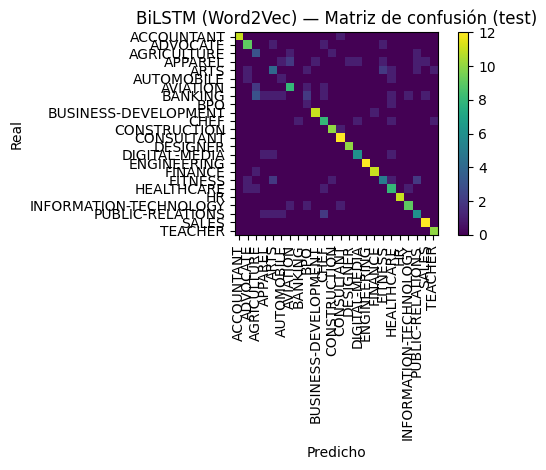

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd, numpy as np, torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device).eval()

# Recorremos test para obtener probs y preds
all_probs, all_preds, all_true = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = best_model(xb)
        probs = torch.softmax(logits, dim=1)
        pred  = probs.argmax(dim=1)
        all_probs.append(probs.cpu().numpy())
        all_preds.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

y_prob = np.concatenate(all_probs, axis=0)
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_true, axis=0)

# Métricas macro/weighted
acc = accuracy_score(y_true, y_pred)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
print({"accuracy":acc, "precision_macro":prec_m, "recall_macro":rec_m, "f1_macro":f1_m,
       "precision_weighted":prec_w, "recall_weighted":rec_w, "f1_weighted":f1_w})

# Reporte por clase
rep = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(NUM_CLASSES)], digits=4, output_dict=True)
df_rep = pd.DataFrame(rep).transpose()
display(df_rep.head(30))

# ROC-AUC macro (OvR)
try:
    roc_macro = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    print("ROC-AUC macro (OvR):", round(float(roc_macro),4))
except Exception as e:
    print("ROC-AUC no disponible:", e)

# Top-2 accuracy
top2 = (np.argsort(-y_prob, axis=1)[:, :2] == y_true.reshape(-1,1)).any(axis=1).mean()
print("Top-2 accuracy:", round(float(top2),4))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("BiLSTM (Word2Vec) — Matriz de confusión (test)")
plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, [id2label[i] for i in range(NUM_CLASSES)], rotation=90)
plt.yticks(ticks, [id2label[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()



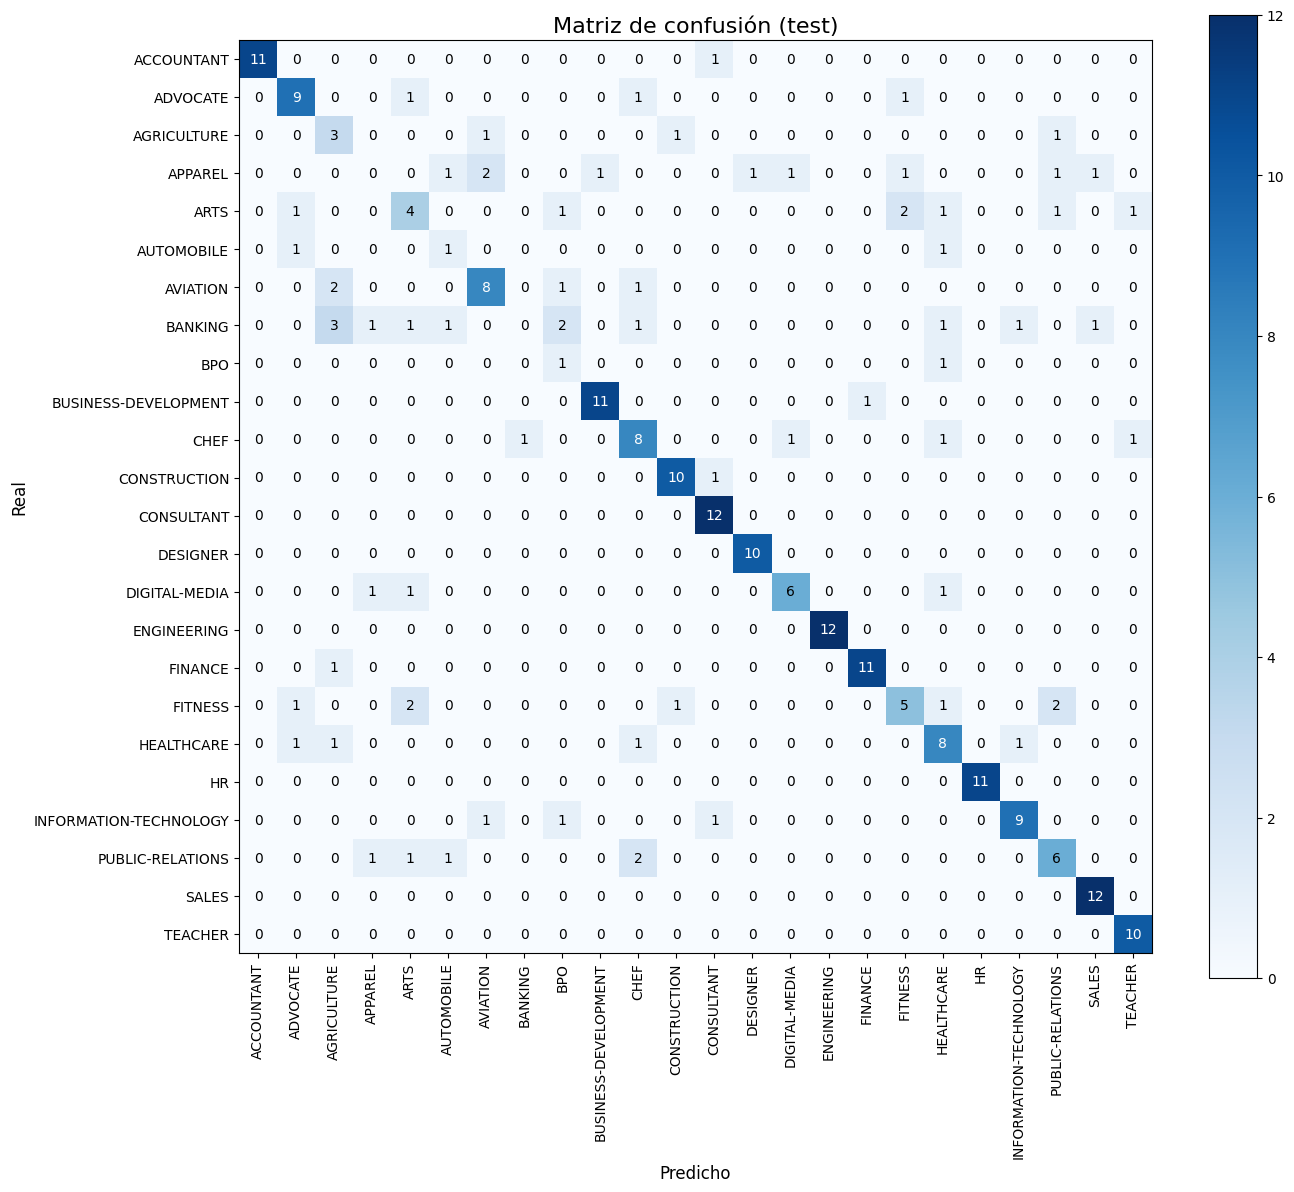

In [16]:
# Matriz de confusión con figura más grande y anotaciones
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))  # ajustar tamaño aquí
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title("Matriz de confusión (test)", fontsize=16)
ticks = np.arange(len(id2label))
labels = [id2label[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel("Predicho", fontsize=12)
ax.set_ylabel("Real", fontsize=12)

# Añadir los números en cada celda
fmt = "d"
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=10)

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import roc_auc_score

try:
    roc_macro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    print("ROC-AUC macro (OvR) en test:", round(float(roc_macro_ovr), 4))
except Exception as e:
    print("ROC-AUC no disponible:", e)


ROC-AUC macro (OvR) en test: 0.9398


In [18]:
def predict_texts(text_list, model=best_model, max_len=100):
    # Tokenize using the same process as in training
    tokens_list = [simple_tokenize(text) for text in text_list]
    # Convert to ids using the same vocabulary
    X = encode_tokens(tokens_list, stoi, max_len)
    # Infer device from model parameters and move tensor there
    device = next(model.parameters()).device
    X = torch.tensor(X, dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(X)
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        pred = prob.argmax(axis=1)
    labels = [id2label[i] for i in pred]
    return labels, prob

# Example:
labels, prob = predict_texts(["Experienced data scientist with NLP background."])
print(f"Predicted label: {labels[0]}")
print(f"Confidence: {prob[0].max():.4f}")


Predicted label: AGRICULTURE
Confidence: 1.0000


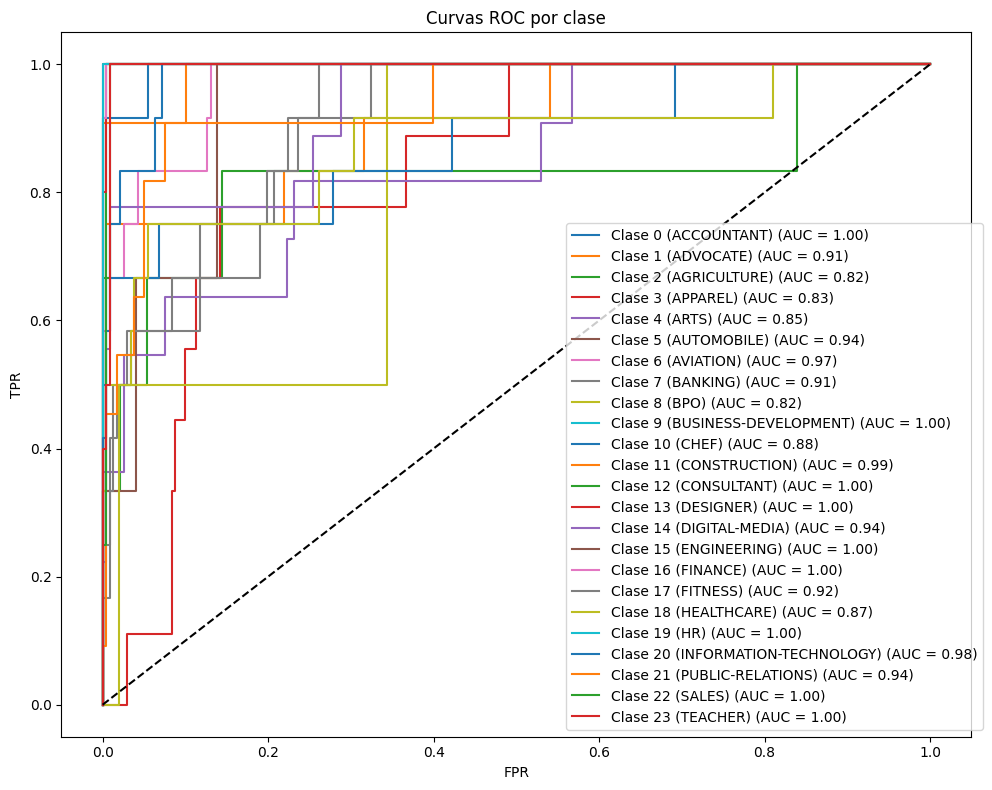

In [19]:
# 8. Curva ROC
# Import only the missing utilities
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# We already have y_prob and y_true from previous computations
probs = y_prob

labels_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} ({id2label.get(i,"")}) (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right', bbox_to_anchor=(1.02, 0))
plt.tight_layout()
plt.show()

In [20]:
if "y_true" in globals() and "y_pred" in globals():
	errores = np.sum(y_true != y_pred)
	total = len(y_true)
	accuracy = (total - errores) / total

	print("=" * 60)
	print(" RESUMEN DE ERRORES - BiLSTM (Word2Vec) ")
	print("=" * 60)
	print(f" Predicciones correctas: {total - errores}")
	print(f" Predicciones incorrectas: {errores}")
	print(f" Total de ejemplos: {total}")
	print(f" Accuracy: {accuracy * 100:.2f}%")
	print(f" Tasa de error: {(errores / total) * 100:.2f}%")
	print("=" * 60)

	# Imprimir classification report si está disponible
	try:
		print("\nClassification report:\n")
		print(classification_report(y_true, y_pred,
									target_names=[id2label[i] for i in range(NUM_CLASSES)],
									digits=4))
	except Exception as e:
		print("No se pudo generar el classification_report:", e)
else:
	raise RuntimeError("Variables 'y_true' y 'y_pred' no encontradas. Ejecuta la evaluación/predicción antes de este cell.")

 RESUMEN DE ERRORES - BiLSTM (Word2Vec) 
 Predicciones correctas: 178
 Predicciones incorrectas: 71
 Total de ejemplos: 249
 Accuracy: 71.49%
 Tasa de error: 28.51%

Classification report:

                        precision    recall  f1-score   support

            ACCOUNTANT     1.0000    0.9167    0.9565        12
              ADVOCATE     0.6923    0.7500    0.7200        12
           AGRICULTURE     0.3000    0.5000    0.3750         6
               APPAREL     0.0000    0.0000    0.0000         9
                  ARTS     0.4000    0.3636    0.3810        11
            AUTOMOBILE     0.2500    0.3333    0.2857         3
              AVIATION     0.6667    0.6667    0.6667        12
               BANKING     0.0000    0.0000    0.0000        12
                   BPO     0.1667    0.5000    0.2500         2
  BUSINESS-DEVELOPMENT     0.9167    0.9167    0.9167        12
                  CHEF     0.5714    0.6667    0.6154        12
          CONSTRUCTION     0.8333    0.90

,precision,recall,f1-score,support
BANKING,0.000000,0.000000,0.000000,12.0
APPAREL,0.000000,0.000000,0.000000,9.0
BPO,0.166667,0.500000,0.250000,2.0
AUTOMOBILE,0.250000,0.333333,0.285714,3.0
AGRICULTURE,0.300000,0.500000,0.375000,6.0
ARTS,0.400000,0.363636,0.380952,11.0
FITNESS,0.555556,0.416667,0.476190,12.0
PUBLIC-RELATIONS,0.545455,0.545455,0.545455,11.0
HEALTHCARE,0.533333,0.666667,0.592593,12.0
CHEF,0.571429,0.666667,0.615385,12.0


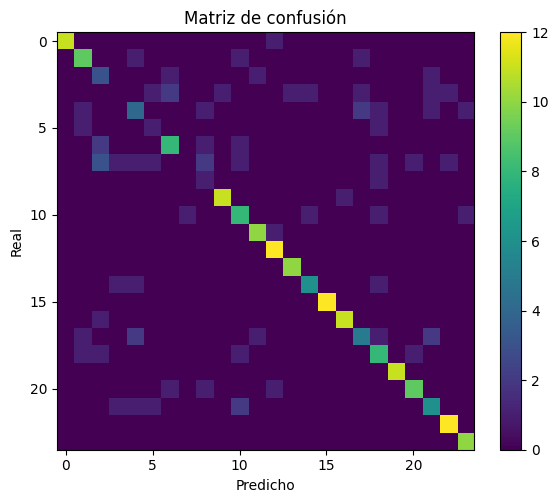

[(3, 'BANKING', 'AGRICULTURE'),
 (2, 'PUBLIC-RELATIONS', 'CHEF'),
 (2, 'FITNESS', 'PUBLIC-RELATIONS'),
 (2, 'FITNESS', 'ARTS'),
 (2, 'BANKING', 'BPO'),
 (2, 'AVIATION', 'AGRICULTURE'),
 (2, 'ARTS', 'FITNESS'),
 (2, 'APPAREL', 'AVIATION'),
 (1, 'PUBLIC-RELATIONS', 'AUTOMOBILE'),
 (1, 'PUBLIC-RELATIONS', 'ARTS')]

: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# y_true, y_pred, y_prob: del último eval en test (ajusta si tus nombres cambian)
rep = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(NUM_CLASSES)],
                            output_dict=True, digits=4)
df_rep = pd.DataFrame(rep).transpose().sort_values('f1-score', ascending=True)
display(df_rep.head(10))  # clases más débiles

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation="nearest"); plt.colorbar()
plt.title("Matriz de confusión"); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout(); plt.show()

# Top confusiones
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i!=j and cm[i,j]>0:
            pairs.append((cm[i,j], id2label[i], id2label[j]))
pairs = sorted(pairs, reverse=True)[:10]
pairs
